In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd

import bacco
import baccoemu
from bacco.cosmo_parameters import TheOne as TheOne_dict
from bacco.cosmo_parameters import nenya_s8 as Nenya_dict

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
# import data_creation_pipeline as dcp
# import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-08-01 02:30:05.640260: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 02:30:05.898798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 02:30:05.900519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 02:30:08.711529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-01 02:30:12.833403: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [17]:
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = False

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    #"ngrid": n_grid,
    #"box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    #"box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
#bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})

args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

In [2]:
redshift_space = False
#??
index_neigh = None
indices_vel = None
sdmhids = None

In [3]:
#basedir = "/cosmos_storage/cosmosims/TheRings_HighRes/TheOne_N2288_L512.0_output/0.00"
#halo_file = "groups_000/fof_subhalo_history_tab_orph_wweight_000"
#basedir = "/cosmos_storage/cosmosims/Resolution_Test/nenya_N256_output"
#basedir = "/cosmos_storage/cosmosims/Rings_Simulations/TheOne_N512_L170/0.00"
basedir = "/cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00"
#basedir = "/cosmos_storage/cosmosims/Rings_Simulations/TheOne_N2288_L512/0.00"
snapnum_init = 0
halo_file_init = f"groups_{snapnum_init:03}/fof_subhalo_history_tab_orph_wweight_{snapnum_init:03}"
sim = bacco.Simulation(basedir=basedir, 
                       halo_file=halo_file_init,
                       )

2024-08-01 02:30:17,354 bacco.sims : Initialising simulation Default
2024-08-01 02:30:17,355 bacco.sims : try /cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/groups_000/fof_subhalo_history_tab_orph_wweight_000
2024-08-01 02:30:17,409 bacco.sims : Loading /cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/groups_000/fof_subhalo_history_tab_orph_wweight_000
2024-08-01 02:30:17,429 bacco.cosmo :    initialization took 0.000 secs
2024-08-01 02:30:17,515 bacco.sims : ...done in 0.0762 s


In [4]:
expfactor_target = 1.0
diff = expfactor_target-sim.snaplist['a']
snapnum = sim.snaplist['snap'][np.argmin(diff[diff>0])]
expfactor = sim.snaplist['a'][np.argmin(diff[diff>0])]
print(snapnum, expfactor)
                               

47 0.983014


In [5]:
cosmo_theone = bacco.Cosmology(**TheOne_dict, expfactor=expfactor)


2024-08-01 02:30:20,526 bacco.cosmo :    initialization took 0.000 secs


In [6]:
halo_file = f"groups_{snapnum:03}/fof_subhalo_history_tab_orph_wweight_{snapnum:03}"
print(halo_file)


groups_047/fof_subhalo_history_tab_orph_wweight_047


In [7]:
sim = bacco.Simulation(basedir=basedir, 
                       sim_cosmology=cosmo_theone, 
                       halo_file=halo_file,
                       )

2024-08-01 02:30:22,507 bacco.sims : Initialising simulation Default
2024-08-01 02:30:22,576 bacco.sims : ...done in 0.00127 s


In [8]:
sim.header

2024-08-01 02:30:24,339 bacco.sims : try /cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/groups_047/fof_subhalo_history_tab_orph_wweight_047
2024-08-01 02:30:24,341 bacco.sims : Loading /cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/groups_047/fof_subhalo_history_tab_orph_wweight_047


{'BoxSize': 512.0,
 'Omega': 0.307112,
 'OmegaBaryon': 0.048252,
 'OmegaLambda': 0.692888,
 'PowerSpectrumFile': '/cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/inputspec_snap.txt',
 'Sigma8': 0.9,
 'As': None,
 'OutputDir': b'./power_N1536_output/0.00/',
 'Redshift': 0.017279838338277065,
 'Time': 0.9830136824823899,
 'ParticleMass': 0.3156997325241908,
 'NpartTotal': 3623878656,
 'Nfiles': 288,
 'Nsample': 1536,
 'HubbleParam': 0.6777,
 'TimeBegin': 0.02,
 'Seed': -406168,
 'ns': 0.9611,
 'w0': -1.0,
 'wa': 0.0,
 'ReNormalizeInputSpectrum': (False,),
 'tau': 0.0952,
 'OmegaNu': 0.0,
 'WhichSpectrum': 2,
 'UseRadiation': 0,
 'Softening': 0.005,
 'FixedInitialAmplitude': 1,
 'Nmesh': 128,
 'UnitLength_in_cm': 3.085678e+24,
 'NewtonsConstant': 43.0071057317063,
 'InitialPhase': 0.0}

In [9]:
n_grid = 512
bmodel = bacco.BiasModel(sim=sim, ngrid=n_grid, sdm=True, mode="sdm", mode_vel="combine",
                        npart_for_fake_sim=n_grid, damping_scale=0.75, bias_model='expansion', mean_num_dens=None,
                        stochastic=False, deposit_method="cic", use_RSD=redshift_space, use_displacement_of_nn=False, interlacing=False,
                        indices=index_neigh, indices_vel=indices_vel, sdmhids=sdmhids)


2024-08-01 02:30:52,946 bacco.BiasModel : Initialising Bias Model class ...


In [10]:
bias_fields = bmodel.bias_terms_lag()

2024-08-01 02:31:03,351 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-08-01 02:31:03,352 bacco.BiasModel : fttw plan
2024-08-01 02:31:03,353 bacco.BiasModel : Computing linear field ...
2024-08-01 02:31:03,354 bacco.BiasModel : Memory used: 1.578463232 Gigabytes


linear field, damping_scale: 0.75
lindelt none
cold true


2024-08-01 02:31:03,888 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.219 secs
2024-08-01 02:31:03,984 bacco.cosmo :    created Pk(z=0) tab from k 7.37789596314542e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 291 P(k) values; Di = (0.991003, 0.981841, 0.973251, 0.973251); nthreads =48; seed =-406168 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =-406168 ngrid=512 pkfixed=1 phase=0.000000, phase_type=0; precision=single 
bacco.lss: computing seed table


2024-08-01 02:31:06,879 bacco.BiasModel : fttw freqs
2024-08-01 02:31:06,880 bacco.BiasModel : tidk freqs
2024-08-01 02:31:12,629 bacco.BiasModel : ifft
2024-08-01 02:31:42,868 bacco.BiasModel : Computing laplacian ...
2024-08-01 02:31:42,870 bacco.BiasModel : Memory used: 6.975148032 Gigabytes
2024-08-01 02:31:44,300 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-08-01 02:31:44,302 bacco.BiasModel : Memory used: 7.508512768 Gigabytes
2024-08-01 02:31:44,541 bacco.BiasModel : Computing delta squared ...
2024-08-01 02:31:44,542 bacco.BiasModel : Memory used: 8.045432832 Gigabytes
2024-08-01 02:31:45,576 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-08-01 02:31:45,578 bacco.BiasModel : Memory used: 8.582316032 Gigabytes


In [11]:
box_size = sim.header['BoxSize']
print(box_size)

512.0


In [12]:
print("Computing eulerian fields")
bias_terms_eul=[]
for ii in range(0,len(bias_fields)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim.sdm['pos'], 
                            mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                            interlacing=False)
    bias_terms_eul.append(bias_terms)
bias_terms_eul = np.array(bias_terms_eul)
# shape was (5, 1, n_grid, n_grid, n_grid); this squeezes out the 1 dimension
bias_terms_eul = np.squeeze(bias_terms_eul)

2024-08-01 02:31:59,468 bacco.sims : Reconstructing sDM
2024-08-01 02:31:59,609 bacco.sims : Reading 31364772 items for sDM/ih_pos


Computing eulerian fields


2024-08-01 02:32:01,044 bacco.sims : Reading 4469414 items for GroupPos
2024-08-01 02:32:01,764 bacco.sims : Reading 31364772 items for sDM/ih_vel
2024-08-01 02:32:03,018 bacco.sims : Reading 4469414 items for GroupVel
2024-08-01 02:32:03,520 bacco.sims : Reading 31364772 items for sDM/offset
2024-08-01 02:32:05,968 bacco.sims : Reading 31364772 items for sDM/pos
2024-08-01 02:32:08,154 bacco.sims : Reading 31364772 items for sDM/vel
2024-08-01 02:32:10,308 bacco.sims : Reading 31364772 items for sDM/ih_ids
2024-08-01 02:32:11,446 bacco.sims : Reading 31364772 items for sDM/ids
2024-08-01 02:32:13,227 bacco.sims : Done reconstructing sDM
2024-08-01 02:32:13,740 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 02:32:13,741 bacco.statistics : starting deposit 1
2024-08-01 02:32:14,524 bacco.statistics :  mesh done in 0.784 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 56623104 particles (134217728 with mass)


2024-08-01 02:32:15,120 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 02:32:15,121 bacco.statistics : starting deposit 1
2024-08-01 02:32:15,778 bacco.statistics :  mesh done in 0.658 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 56623104 particles (134217728 with mass)


2024-08-01 02:32:16,330 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 02:32:16,331 bacco.statistics : starting deposit 1
2024-08-01 02:32:16,959 bacco.statistics :  mesh done in 0.629 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 56623104 particles (134217728 with mass)


2024-08-01 02:32:17,518 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 02:32:17,519 bacco.statistics : starting deposit 1
2024-08-01 02:32:18,133 bacco.statistics :  mesh done in 0.615 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 56623104 particles (134217728 with mass)


2024-08-01 02:32:18,677 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 02:32:18,678 bacco.statistics : starting deposit 1
2024-08-01 02:32:19,287 bacco.statistics :  mesh done in 0.61 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 56623104 particles (134217728 with mass)


0.0 5008.806
0.0 5008.806


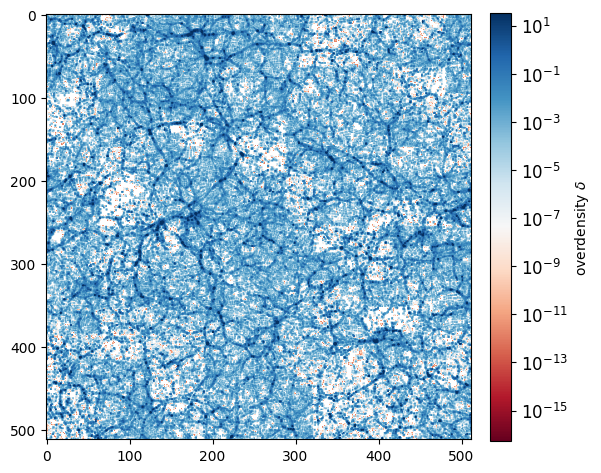

In [13]:
plotter.plot_field(bias_terms_eul[0], log=True)

In [18]:
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
power_all_terms = bmodel.compute_power_terms(kmin=k_min, kmax=k_max, nbins=n_bins, log_binning=True,
                                             #deconvolve_grid=False
                                             )

2024-07-30 23:52:31,989 bacco.BiasModel : Computing power spectra of bias terms ...
2024-07-30 23:52:31,991 bacco.BiasModel : Memory used: 24.121851904 Gigabytes
2024-07-30 23:52:31,992 bacco.BiasModel : Computing bias model power spectra...
2024-07-30 23:52:31,993 bacco.BiasModel : 0.999021
2024-07-30 23:52:32,417 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.103 secs
2024-07-30 23:52:32,419 bacco.cosmo :    created Pk(z=0) tab from k 7.37789596314542e-05 to 100000.0 h/Mpc
2024-07-30 23:52:31,993 bacco.BiasModel : 
    -----------------------------------------------
            TheOne cosmology
            LCDM model 
            ------------------------------------
            Ω cold dark matter = 0.25886
            Ω baryon = 0.048252
            Ω cold matter = 0.307112
            Ω matter = 0.307112
            Ω dark energy = 0.692888
            Ω neutrino  = 0.0 
            Ω radiation = 0.0
            Ω curvature = 0.0
            Ω total = 1.0
            Σ

bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-30 23:58:50,129 bacco.BiasModel : mesh #2
2024-07-30 23:58:50,129 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-30 23:58:50,130 bacco.statistics : starting deposit 1
2024-07-30 23:58:54,868 bacco.statistics :  mesh done in 4.74 s
2024-07-30 23:58:54,869 bacco.BiasModel : mesh #3
2024-07-30 23:58:54,870 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-30 23:58:54,871 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-30 23:58:59,650 bacco.statistics :  mesh done in 4.78 s
2024-07-30 23:58:59,651 bacco.BiasModel : mesh #4
2024-07-30 23:58:59,651 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-30 23:58:59,652 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-30 23:59:04,494 bacco.statistics :  mesh done in 4.84 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-30 23:59:05,051 bacco.BiasModel : Finished computing bias terms in lagrangian space and moving to Eulerian.
2024-07-30 23:59:05,053 bacco.BiasModel : Defining prod...
2024-07-30 23:59:05,054 bacco.BiasModel : np.arange(bias_terms_eul.shape[0]) = [0 1 2 3 4]


0


2024-07-30 23:59:08,678 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-07-30 23:59:08,682 bacco.cosmo :    computed halofit at z=0.00 for 'TheOne' in 0.002 secs


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.273301 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.489148 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:14,639 bacco.statistics :  ...done in 5.96 s


1


2024-07-30 23:59:15,873 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -4.79861e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.301947 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.480127 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000137 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:21,586 bacco.statistics :  ...done in 5.71 s


2


2024-07-30 23:59:22,802 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -2.23343e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.317134 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.496247 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000131 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:28,516 bacco.statistics :  ...done in 5.71 s


3


2024-07-30 23:59:29,754 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -2.94982e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.445705 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.496471 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000383 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:35,681 bacco.statistics :  ...done in 5.93 s


4


2024-07-30 23:59:36,924 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.02717e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.115542 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.487453 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000136 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:42,216 bacco.statistics :  ...done in 5.29 s


5


2024-07-30 23:59:43,398 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.79861e-11 (grid1) -4.79861e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.361422 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.483015 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000140 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:49,099 bacco.statistics :  ...done in 5.7 s


6


2024-07-30 23:59:50,355 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.79861e-11 (grid1) -2.23343e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.449826 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.498043 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000151 secs
bacco.power : Deallocating arrays


2024-07-30 23:59:56,617 bacco.statistics :  ...done in 6.26 s


7


2024-07-30 23:59:57,766 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.79861e-11 (grid1) -2.94982e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.082131 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.483683 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000289 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:03,273 bacco.statistics :  ...done in 5.51 s


8


2024-07-31 00:00:04,537 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.79861e-11 (grid1) 9.02717e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.360062 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.476999 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000135 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:10,586 bacco.statistics :  ...done in 6.05 s


9


2024-07-31 00:00:11,759 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.23343e-06 (grid1) -2.23343e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.115877 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.482078 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:17,459 bacco.statistics :  ...done in 5.7 s


10


2024-07-31 00:00:18,719 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.23343e-06 (grid1) -2.94982e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.195228 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.485811 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000145 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:24,570 bacco.statistics :  ...done in 5.85 s


11


2024-07-31 00:00:25,846 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.23343e-06 (grid1) 9.02717e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.295013 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.497084 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000143 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:31,711 bacco.statistics :  ...done in 5.87 s


12


2024-07-31 00:00:32,871 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.94982e-06 (grid1) -2.94982e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.342997 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.501812 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:38,656 bacco.statistics :  ...done in 5.78 s


13


2024-07-31 00:00:39,816 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=0); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.94982e-06 (grid1) 9.02717e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.315176 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.485388 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000185 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:45,757 bacco.statistics :  ...done in 5.94 s


14


2024-07-31 00:00:46,910 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.02717e-11 (grid1) 9.02717e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.349831 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.515567 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-07-31 00:00:53,013 bacco.statistics :  ...done in 6.1 s
2024-07-31 00:00:53,186 bacco.BiasModel : Done computing power spectra terms.


In [19]:
#fields = bmodel.get_eul_field_terms()

In [20]:
# pos_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim.sdm['pos'], vel=None, mass=None,
#                  interlacing=False, deposit_method='cic', folds=1,
#                  zspace=False, cosmology=cosmo_theone, nthreads=None, twod=False)
# print(pos_mesh.shape)

In [21]:
#fields = bmodel.get_eul_field_terms()

### Load in emu

In [27]:
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
kk = power_all_terms[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

cosmo_params_emu_theone = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_theone)
_, pnn_emu_theone = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_theone)

NameError: name 'power_all_terms' is not defined

12


/tmp/ipykernel_276650/2650886277.py:22: RuntimeWarning: divide by zero encountered in divide
  ax_err[contf].semilogx(kk_emu, (pnn_emu[ii]-pk_pred[i_k_emu])/pk_pred[i_k_emu],


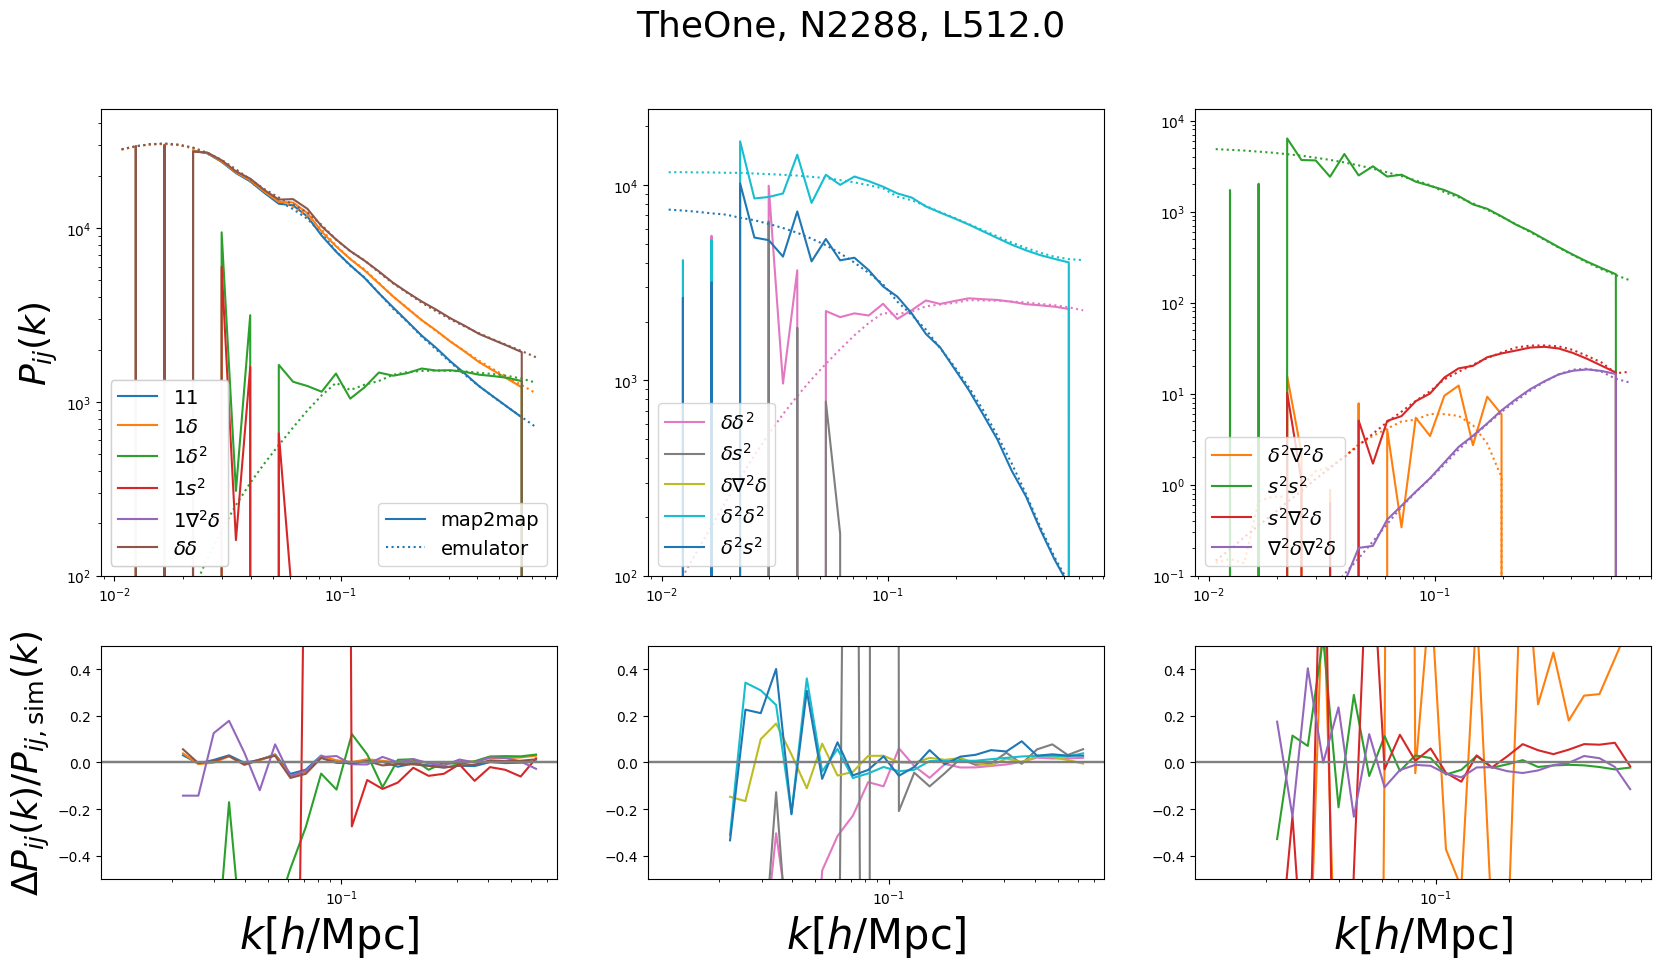

In [35]:
fig, axarr = plt.subplots(2, 3, figsize=(20,10), height_ratios=[2,1])
ax, ax_err = axarr

pnn_emu = pnn_emu_theone
labels_pnn = utils.labels_pnn

plt.suptitle(f'TheOne, N{sim.header["Nsample"]}, L{box_size}', fontsize=26)

contf=0
for ii in range(len(power_all_terms)):
    #mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    # pk_sim = power_all_terms_sim[ii]['pk'][mask]
    # pk_pred = power_all_terms_pred[ii]['pk'][mask]
    
    pk_pred = power_all_terms[ii]['pk']

    ax[contf].loglog(kk, pk_pred,
                       color='C'+str(ii), label=labels_pnn[ii])
    ax[contf].loglog(kk_emu, pnn_emu[ii], ls=':', color='C'+str(ii), 
                     )
    
    ax_err[contf].semilogx(kk_emu, (pnn_emu[ii]-pk_pred[i_k_emu])/pk_pred[i_k_emu], 
                         ls='-', color='C'+str(ii),)
    
    ax[contf].legend(loc='lower left', frameon=True, fancybox=True, fontsize=14)
    
    ax_err[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    ax_err[contf].axhline(0, ls='-', color='grey')
    ax_err[contf].set_ylim(-0.5, 0.5)
    
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$P_{ij}(k)$', size=26)
ax_err[0].set_ylabel(r'$\Delta P_{ij}(k) / P_{ij,\text{sim}}(k)$', size=26)
ax[0].set_ylim(1e2)
ax[1].set_ylim(1e2)
ax[2].set_ylim(1e-1)

# where some data has already been plotted to ax
handles, labels = ax[0].get_legend_handles_labels()
lines = ax[0].get_lines()
print(len(lines))
legend = ax[0].legend([lines[i] for i in [0,1]], ["map2map", "emulator"], loc='lower right',
                      frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend)

legend_orig = ax[0].legend(handles, labels, loc='lower left',
                           frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend_orig)

/tmp/ipykernel_276650/3123752285.py:20: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls=':', alpha=alpha, color=color, lw=lw)


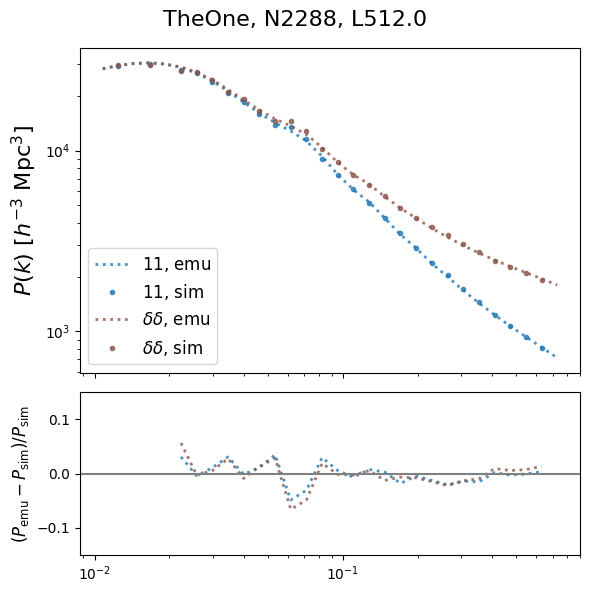

In [33]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

plt.suptitle(f'TheOne, N{sim.header["Nsample"]}, L{box_size}', fontsize=16)

color_pdd = 'C'+str(5)

k = kk
lw = 2

is_pnn = [0,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], ls=':', alpha=alpha, label=f'{labels_pnn[i_pnn]}, emu', color=color, lw=lw)
    axarr[0].plot(kk, pk_obj['pk'], ls='None', marker='o', markersize=3, alpha=alpha, label=f'{labels_pnn[i_pnn]}, sim', color=color)
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls=':', alpha=alpha, color=color, lw=lw)

ax1.axhline(0.0, color='grey')

ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

In [26]:
# # don't know why i have to do this here but hit error
# sim._Mpc_norm = sim.header['UnitLength_in_cm'] / 3.085678e+24 
pk_sdm = sim.get_sdmPower(ngrid=n_grid, deposit_method='cic', kmin=k_min, kmax=k_max, nbins=n_bins,
                          log_binning=True, interlacing=False)

2024-07-31 00:01:13,094 bacco.sims : Computing sdm-P(k)
2024-07-31 00:01:14,177 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-07-31 00:01:14,179 bacco.statistics :  setting the grid 512 False
2024-07-31 00:01:14,180 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-31 00:01:14,180 bacco.statistics : starting deposit 1
2024-07-31 00:01:20,738 bacco.statistics :  mesh done in 6.56 s
2024-07-31 00:01:20,740 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 187149248 particles (187149248 with mass)
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0


2024-07-31 00:01:22,335 bacco.statistics :  done compute.power
2024-07-31 00:01:22,337 bacco.statistics :  power done in 8.16 s


bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.87207e+08 (grid1) 1.87207e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.546010 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.431696 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


In [16]:
norm = n_grid**3
pk_objs_hr_bfields = []
for i in range(len(bias_fields)):
    pk_obj_hr_bfield = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=bias_fields[i]/norm,
                    grid2=bias_fields[i]/norm,
                    cosmology=cosmo_theone,
                    ngrid=n_grid,
                    box=box_size,
                    **args_power_grid_deconvolveFalse)
    pk_objs_hr_bfields.append(pk_obj_hr_bfield)

2024-08-01 02:35:25,216 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-01 02:35:25,220 bacco.cosmo :    computed halofit at z=0.02 for 'TheOne' in 0.002 secs


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.079021 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.501303 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000275 secs
bacco.power : Deallocating arrays


2024-08-01 02:35:33,125 bacco.statistics :  ...done in 7.91 s
2024-08-01 02:35:34,769 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -8.29901e-11 (grid1) -8.29901e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.276936 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.488001 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000158 secs
bacco.power : Deallocating arrays


2024-08-01 02:35:43,956 bacco.statistics :  ...done in 9.19 s
2024-08-01 02:35:45,601 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 4.58571e-06 (grid1) 4.58571e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.182551 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.486988 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000415 secs
bacco.power : Deallocating arrays


2024-08-01 02:35:54,251 bacco.statistics :  ...done in 8.65 s
2024-08-01 02:35:55,896 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -2.52326e-06 (grid1) -2.52326e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.263868 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.508280 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000164 secs
bacco.power : Deallocating arrays


2024-08-01 02:36:04,375 bacco.statistics :  ...done in 8.48 s
2024-08-01 02:36:05,959 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.25471e-11 (grid1) 1.25471e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.122226 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.473560 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000145 secs
bacco.power : Deallocating arrays


2024-08-01 02:36:14,467 bacco.statistics :  ...done in 8.51 s


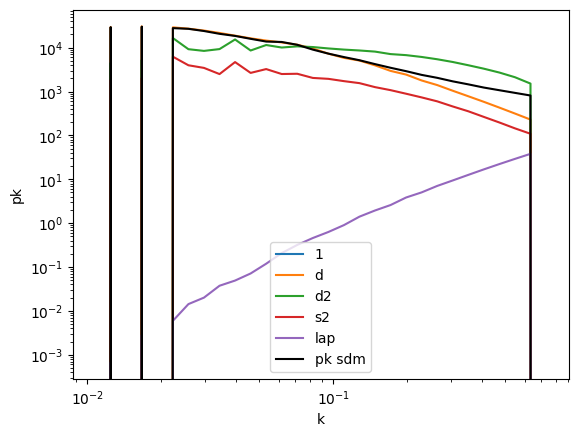

In [28]:
labels_lag_fields = ['1', 'd', 'd2', 's2', 'lap']
for i in range(len(bias_fields)):
    plt.loglog(pk_objs_hr_bfields[i]['k'], pk_objs_hr_bfields[i]['pk'], 
               label=labels_lag_fields[i])

plt.loglog(pk_sdm['k'], pk_sdm['pk'], 
           color='k', label='pk sdm')

#plt.xlim(pk_objs_hr_bfields[0]['k'].min(), pk_objs_hr_bfields[0]['k'].max())
#plt.ylim(1e-1, 1e5)

plt.xlabel('k')
plt.ylabel('pk')
plt.legend()

/tmp/ipykernel_276650/1248492845.py:32: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_276650/1248492845.py:35: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_276650/1248492845.py:50: RuntimeWarning: invalid value encountered in divide
  (pk_objs_hr_bfields[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_276650/1248492845.py:58: RuntimeWarning: invalid value encountered in divide
  (pk_sdm['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


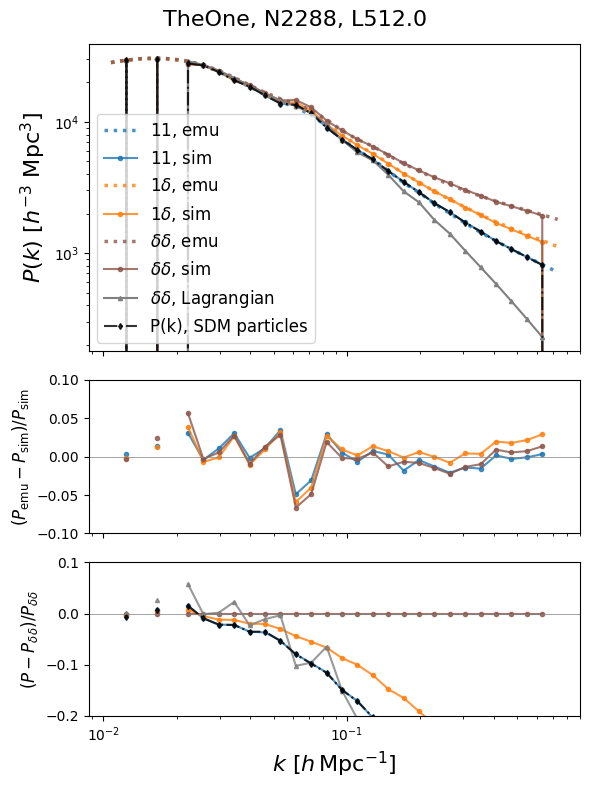

In [29]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

plt.suptitle(f'TheOne, N{sim.header["Nsample"]}, L{box_size}', fontsize=16)

color_pdd = 'C'+str(5)

k = kk
lw = 1.5
lw_emu = 2.5

i_pnn_compare = 5
pk_obj_compare = power_all_terms[i_pnn_compare]

is_pnn = [0,1,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    # mask = pk_obj['pk'] > 0
    # kk_emu = kk_emu[mask]
    # kk = kk[mask]
    # pk = pk_obj['pk'][mask]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=f'{labels_pnn[i_pnn]}, emu', 
                  ls=':', alpha=alpha, color=color, lw=lw_emu)
    axarr[0].plot(kk, pk_obj['pk'], 
                  ls='-', lw=lw, alpha=alpha, color=color,
                  marker='o', markersize=3, 
                  label=f'{labels_pnn[i_pnn]}, sim')
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                  marker='o', markersize=3, 
                  ls='-', lw=lw, alpha=alpha, color=color)
    axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  ls='-', lw=lw, 
                  marker='o', markersize=3, 
                  alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
is_pnn_lag = [1]
for i_pnn_lag in is_pnn_lag:
    i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
    label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
    axarr[0].plot(pk_objs_hr_bfields[i_pnn_lag]['k'], pk_objs_hr_bfields[i_pnn_lag]['pk'], 
                  marker='^', markersize=3, 
                  label=label, color='grey')
    axarr[2].plot(pk_objs_hr_bfields[i_pnn_lag]['k'], 
                  (pk_objs_hr_bfields[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  marker='^', markersize=3, 
                  ls='-', alpha=alpha, color='grey', lw=lw)

axarr[0].plot(pk_sdm['k'], pk_sdm['pk'], 
           marker='d', markersize=3, 
           color='k', alpha=alpha, ls='-.',lw=lw, label='P(k), SDM particles')
axarr[2].plot(pk_sdm['k'],
            (pk_sdm['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
             marker='d', markersize=3, 
             alpha=alpha, color='black',  ls='-.', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.2, 0.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

### Try with my code 

In [14]:
lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid), num=30)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_theone, expfactor=cosmo_theone.expfactor, wavemode=lt_k)

2024-08-01 02:33:31,093 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.129 secs
2024-08-01 02:33:31,095 bacco.cosmo :    created Pk(z=0) tab from k 7.37789596314542e-05 to 100000.0 h/Mpc


In [33]:
n_grid

512

In [51]:
#Compute the P(k) of the 15 terms
import itertools

prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_x.shape[0]),r=2)))

bias_terms_eul_norm = bias_terms_eul_x/n_grid**3
power_all_terms_manual = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power_grid_ii = args_power_grid.copy()
    args_power_grid_ii['correct_grid'] = False if ii == 11 else True
    print(prod[ii])
    power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm[prod[ii,1]],
                                                    #normalise_grid1=False,
                                                    #normalise_grid2=False,
                                                    #deconvolve_grid1=True,
                                                    #deconvolve_grid2=True,
                                                    ngrid=n_grid,
                                                    cosmology=cosmo_theone,
                                                    box=box_size,
                                                    **args_power_grid_ii)
    power_all_terms_manual.append(power_term)
    #break
#print(power_all_terms_manual[0])

2024-08-01 03:22:16,326 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.009416 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.492033 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-08-01 03:22:23,651 bacco.statistics :  ...done in 7.32 s
2024-08-01 03:22:23,653 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 1]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -5.75921e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.049626 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.486030 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-08-01 03:22:30,627 bacco.statistics :  ...done in 6.97 s
2024-08-01 03:22:30,629 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 2]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 4.58947e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.000050 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.479739 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000145 secs
bacco.power : Deallocating arrays


2024-08-01 03:22:37,945 bacco.statistics :  ...done in 7.32 s
2024-08-01 03:22:37,947 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -2.52315e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.993129 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.489817 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-08-01 03:22:45,150 bacco.statistics :  ...done in 7.2 s
2024-08-01 03:22:45,152 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -6.35957e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.994988 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.478038 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-08-01 03:22:52,567 bacco.statistics :  ...done in 7.41 s
2024-08-01 03:22:52,568 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.75921e-11 (grid1) -5.75921e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.007773 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.485126 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000139 secs
bacco.power : Deallocating arrays


2024-08-01 03:22:59,628 bacco.statistics :  ...done in 7.06 s
2024-08-01 03:22:59,630 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 2]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.75921e-11 (grid1) 4.58947e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.046953 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.480126 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000151 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:07,521 bacco.statistics :  ...done in 7.89 s
2024-08-01 03:23:07,522 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.75921e-11 (grid1) -2.52315e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.009483 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.478676 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:14,520 bacco.statistics :  ...done in 7.0 s
2024-08-01 03:23:14,521 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.75921e-11 (grid1) -6.35957e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.997073 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.477196 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:21,517 bacco.statistics :  ...done in 7.0 s
2024-08-01 03:23:21,519 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 2]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 4.58947e-06 (grid1) 4.58947e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.021101 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.496118 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000151 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:28,335 bacco.statistics :  ...done in 6.82 s
2024-08-01 03:23:28,336 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 4.58947e-06 (grid1) -2.52315e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.072387 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.478905 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:35,203 bacco.statistics :  ...done in 6.87 s
2024-08-01 03:23:35,204 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 4.58947e-06 (grid1) -6.35957e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.064619 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.488254 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:42,625 bacco.statistics :  ...done in 7.42 s
2024-08-01 03:23:42,627 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[3 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.52315e-06 (grid1) -2.52315e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.000191 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.492748 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000172 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:49,399 bacco.statistics :  ...done in 6.77 s
2024-08-01 03:23:49,400 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[3 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.52315e-06 (grid1) -6.35957e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.047602 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.505193 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000177 secs
bacco.power : Deallocating arrays


2024-08-01 03:23:56,131 bacco.statistics :  ...done in 6.73 s
2024-08-01 03:23:56,132 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[4 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -6.35957e-11 (grid1) -6.35957e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.990242 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.477977 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-08-01 03:24:02,597 bacco.statistics :  ...done in 6.46 s


In [28]:
kk = power_all_terms_manual[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

cosmo_params_emu_theone = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_theone)
_, pnn_emu_theone = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_theone)

/tmp/ipykernel_398216/1976954138.py:35: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_398216/1976954138.py:38: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_398216/1976954138.py:53: RuntimeWarning: invalid value encountered in divide
  (pk_objs_hr_bfields[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


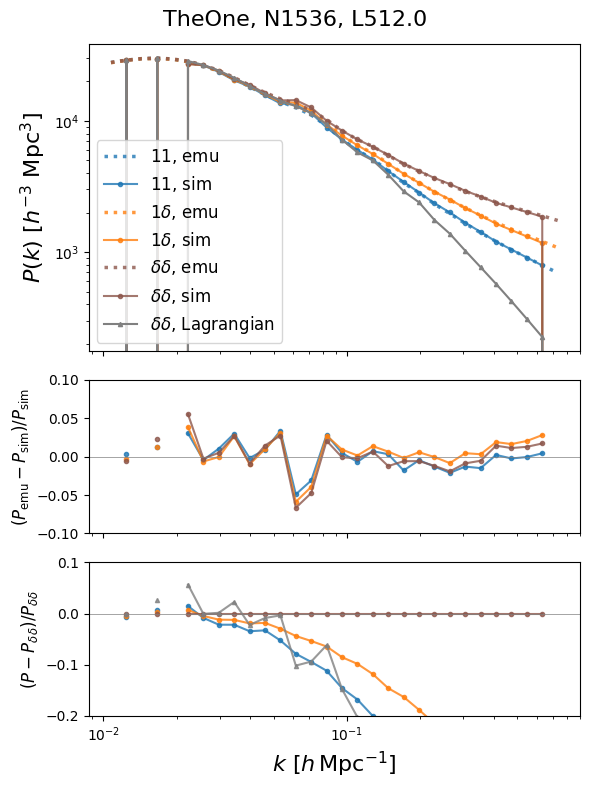

In [52]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

plt.suptitle(f'TheOne, N{sim.header["Nsample"]}, L{box_size}', fontsize=16)

color_pdd = 'C'+str(5)

k = kk
lw = 1.5
lw_emu = 2.5

pnn_emu = pnn_emu_theone
power_all_terms = power_all_terms_manual

i_pnn_compare = 5
pk_obj_compare = power_all_terms[i_pnn_compare]

is_pnn = [0,1,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    # mask = pk_obj['pk'] > 0
    # kk_emu = kk_emu[mask]
    # kk = kk[mask]
    # pk = pk_obj['pk'][mask]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=f'{utils.labels_pnn[i_pnn]}, emu', 
                  ls=':', alpha=alpha, color=color, lw=lw_emu)
    axarr[0].plot(kk, pk_obj['pk'], 
                  ls='-', lw=lw, alpha=alpha, color=color,
                  marker='o', markersize=3, 
                  label=f'{utils.labels_pnn[i_pnn]}, sim')
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                  marker='o', markersize=3, 
                  ls='-', lw=lw, alpha=alpha, color=color)
    axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  ls='-', lw=lw, 
                  marker='o', markersize=3, 
                  alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
is_pnn_lag = [1]
for i_pnn_lag in is_pnn_lag:
    i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
    label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
    axarr[0].plot(pk_objs_hr_bfields[i_pnn_lag]['k'], pk_objs_hr_bfields[i_pnn_lag]['pk'], 
                  marker='^', markersize=3, 
                  label=label, color='grey')
    axarr[2].plot(pk_objs_hr_bfields[i_pnn_lag]['k'], 
                  (pk_objs_hr_bfields[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  marker='^', markersize=3, 
                  ls='-', alpha=alpha, color='grey', lw=lw)

# axarr[0].plot(pk_sdm['k'], pk_sdm['pk'], 
#            marker='d', markersize=3, 
#            color='k', alpha=alpha, ls='-.',lw=lw, label='P(k), SDM particles')
# axarr[2].plot(pk_sdm['k'],
#             (pk_sdm['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
#              marker='d', markersize=3, 
#              alpha=alpha, color='black',  ls='-.', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.2, 0.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

In [59]:
#Compute the P(k) of the 15 terms
import itertools

prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_x.shape[0]),r=2)))

bias_terms_eul_norm = bias_terms_eul/n_grid**3
power_all_terms_manual_noind = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power_grid_ii = args_power_grid.copy()
    args_power_grid_ii['correct_grid'] = False if ii == 11 else True
    print(prod[ii])
    power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm[prod[ii,1]],
                                                    #normalise_grid1=False,
                                                    #normalise_grid2=False,
                                                    #deconvolve_grid1=True,
                                                    #deconvolve_grid2=True,
                                                    ngrid=n_grid,
                                                    cosmology=cosmo_theone,
                                                    box=box_size,
                                                    **args_power_grid_ii)
    power_all_terms_manual_noind.append(power_term)
    #break
#print(power_all_terms_manual[0])

2024-08-01 03:36:05,079 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.421875 (grid1) 0.421875 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.059822 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.487355 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:12,404 bacco.statistics :  ...done in 7.33 s
2024-08-01 03:36:12,406 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 1]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.421875 (grid1) 0.0066753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.414220 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.902278 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000325 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:19,881 bacco.statistics :  ...done in 7.47 s
2024-08-01 03:36:19,882 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 2]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.421875 (grid1) 0.00277454 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.085944 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.491051 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000140 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:27,702 bacco.statistics :  ...done in 7.82 s
2024-08-01 03:36:27,704 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.421875 (grid1) 0.000957808 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.057660 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.499995 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:34,515 bacco.statistics :  ...done in 6.81 s
2024-08-01 03:36:34,516 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.421875 (grid1) -1.22885e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.079871 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.480647 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000156 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:42,643 bacco.statistics :  ...done in 8.13 s
2024-08-01 03:36:42,645 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.0066753 (grid1) 0.0066753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.052872 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.481387 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:49,929 bacco.statistics :  ...done in 7.28 s
2024-08-01 03:36:49,930 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 2]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.0066753 (grid1) 0.00277454 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.040977 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.492279 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000135 secs
bacco.power : Deallocating arrays


2024-08-01 03:36:56,753 bacco.statistics :  ...done in 6.82 s
2024-08-01 03:36:56,754 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.0066753 (grid1) 0.000957808 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.109940 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.477025 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:04,018 bacco.statistics :  ...done in 7.26 s
2024-08-01 03:37:04,020 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.0066753 (grid1) -1.22885e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.042013 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.491020 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:10,644 bacco.statistics :  ...done in 6.62 s
2024-08-01 03:37:10,646 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 2]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.00277454 (grid1) 0.00277454 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.025909 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.477946 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:17,496 bacco.statistics :  ...done in 6.85 s
2024-08-01 03:37:17,497 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.00277454 (grid1) 0.000957808 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.051804 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.497432 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000177 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:24,254 bacco.statistics :  ...done in 6.76 s
2024-08-01 03:37:24,256 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.00277454 (grid1) -1.22885e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.469992 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.532411 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000217 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:31,382 bacco.statistics :  ...done in 7.13 s
2024-08-01 03:37:31,383 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[3 3]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.000957808 (grid1) 0.000957808 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.104843 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.487236 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000163 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:38,282 bacco.statistics :  ...done in 6.9 s
2024-08-01 03:37:38,284 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[3 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.000957808 (grid1) -1.22885e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.018780 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.493672 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000146 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:45,538 bacco.statistics :  ...done in 7.25 s
2024-08-01 03:37:45,540 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[4 4]
bacco.power : boxsize 512.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.22885e-05 (grid1) -1.22885e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.099914 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.505729 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-08-01 03:37:52,009 bacco.statistics :  ...done in 6.47 s


/tmp/ipykernel_398216/257395918.py:35: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_398216/257395918.py:38: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_398216/257395918.py:53: RuntimeWarning: invalid value encountered in divide
  (pk_objs_hr_bfields[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


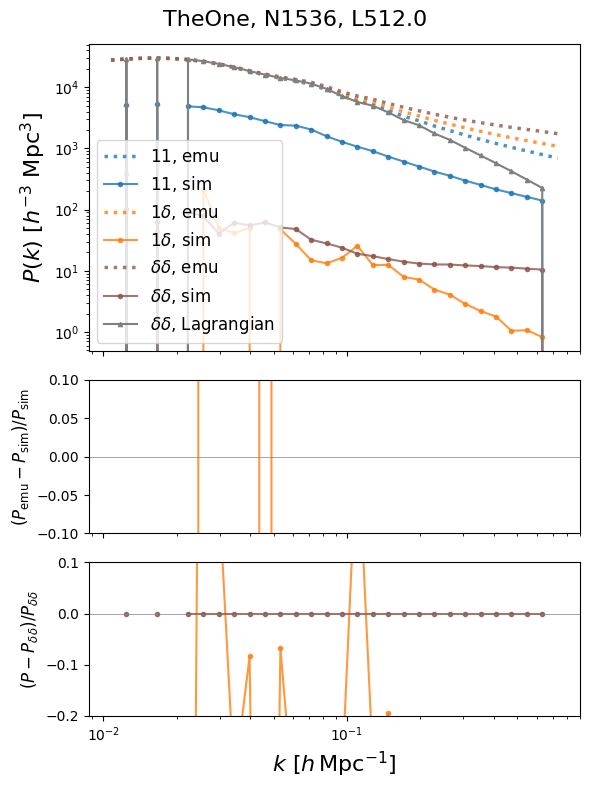

In [60]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

plt.suptitle(f'TheOne, N{sim.header["Nsample"]}, L{box_size}', fontsize=16)

color_pdd = 'C'+str(5)

k = kk
lw = 1.5
lw_emu = 2.5

pnn_emu = pnn_emu_theone
power_all_terms = power_all_terms_manual_noind

i_pnn_compare = 5
pk_obj_compare = power_all_terms[i_pnn_compare]

is_pnn = [0,1,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    # mask = pk_obj['pk'] > 0
    # kk_emu = kk_emu[mask]
    # kk = kk[mask]
    # pk = pk_obj['pk'][mask]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=f'{utils.labels_pnn[i_pnn]}, emu', 
                  ls=':', alpha=alpha, color=color, lw=lw_emu)
    axarr[0].plot(kk, pk_obj['pk'], 
                  ls='-', lw=lw, alpha=alpha, color=color,
                  marker='o', markersize=3, 
                  label=f'{utils.labels_pnn[i_pnn]}, sim')
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                  marker='o', markersize=3, 
                  ls='-', lw=lw, alpha=alpha, color=color)
    axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  ls='-', lw=lw, 
                  marker='o', markersize=3, 
                  alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
is_pnn_lag = [1]
for i_pnn_lag in is_pnn_lag:
    i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
    label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
    axarr[0].plot(pk_objs_hr_bfields[i_pnn_lag]['k'], pk_objs_hr_bfields[i_pnn_lag]['pk'], 
                  marker='^', markersize=3, 
                  label=label, color='grey')
    axarr[2].plot(pk_objs_hr_bfields[i_pnn_lag]['k'], 
                  (pk_objs_hr_bfields[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  marker='^', markersize=3, 
                  ls='-', alpha=alpha, color='grey', lw=lw)

# axarr[0].plot(pk_sdm['k'], pk_sdm['pk'], 
#            marker='d', markersize=3, 
#            color='k', alpha=alpha, ls='-.',lw=lw, label='P(k), SDM particles')
# axarr[2].plot(pk_sdm['k'],
#             (pk_sdm['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
#              marker='d', markersize=3, 
#              alpha=alpha, color='black',  ls='-.', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.2, 0.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

In [41]:
bias_terms_eul_orig = bmodel.get_eul_field_terms(LPT_disp=False,LPT_order=None,RSD_direction='z',
                                                 bias_terms_lagrangian=bias_fields,\
                                            third_order_terms=False,\
                                            second_order_non_local_terms=False,\
                                            d2_renorm_order=1,\
                                            s2_renorm_order=1)

2024-08-01 02:57:01,462 bacco.BiasModel : Computing expansion bias terms in eulerian coords ...
2024-08-01 02:57:01,464 bacco.BiasModel : Memory used: 25.09891584 Gigabytes
2024-08-01 02:57:01,465 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-08-01 02:57:01,465 bacco.BiasModel : fttw plan
2024-08-01 02:57:01,469 bacco.BiasModel : fttw freqs
2024-08-01 02:57:01,469 bacco.BiasModel : tidk freqs
2024-08-01 02:57:08,183 bacco.BiasModel : ifft
2024-08-01 02:57:38,603 bacco.BiasModel : Computing laplacian ...
2024-08-01 02:57:38,606 bacco.BiasModel : Memory used: 29.931687936 Gigabytes
2024-08-01 02:57:43,865 bacco.BiasModel : Transforming to eulerian coords ...
2024-08-01 02:57:43,867 bacco.BiasModel : Memory used: 27.784101888 Gigabytes
2024-08-01 02:57:43,868 bacco.BiasModel : Finding indices from lagrangian neighbours ...
2024-08-01 02:57:43,869 bacco.BiasModel : Memory used: 27.784101888 Gigabytes
2024-08-01 02:57:43,869 bacco.BiasModel : Computing regular grid

bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 02:59:56,015 bacco.statistics :  mesh done in 4.25 s
2024-08-01 02:59:56,017 bacco.BiasModel : mesh #2
2024-08-01 02:59:56,017 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 02:59:56,018 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 03:00:00,375 bacco.statistics :  mesh done in 4.36 s
2024-08-01 03:00:00,377 bacco.BiasModel : mesh #3
2024-08-01 03:00:00,378 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:00:00,378 bacco.statistics : starting deposit 1
2024-08-01 03:00:05,014 bacco.statistics :  mesh done in 4.64 s
2024-08-01 03:00:05,016 bacco.BiasModel : mesh #4
2024-08-01 03:00:05,017 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:00:05,017 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 03:00:09,288 bacco.statistics :  mesh done in 4.27 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [42]:
for i in range(len(bias_terms_eul)):
    print(np.min(bias_terms_eul[i]), np.max(bias_terms_eul[i]))
    
for i in range(len(bias_terms_eul_orig)):
    print(np.min(bias_terms_eul_orig[i]), np.max(bias_terms_eul_orig[i]))

0.0 1528.412
-669.2763 400.64468
-1017.0843 914.4289
-253.7505 373.50125
-55.790565 115.68887
0.0 3620.4312
-88.17341 8515.718
-391.60623 26524.045
-1737.805 2178.2305
-623.05743 56.14999


In [46]:
for i in range(len(bias_terms_eul_x)):
    print(np.min(bias_terms_eul_x[i]), np.max(bias_terms_eul_x[i]))

0.0 3620.4312
-88.17341 8515.718
-391.60623 26524.045
-1737.805 2178.2305
-623.05743 56.14999


In [44]:
x = bmodel.transform_to_eulerian(LPT_disp=False, RSD_direction='z')

2024-08-01 03:05:28,233 bacco.BiasModel : Transforming to eulerian coords ...
2024-08-01 03:05:28,236 bacco.BiasModel : Memory used: 22.990794752 Gigabytes
2024-08-01 03:05:28,236 bacco.BiasModel : Finding indices from lagrangian neighbours ...
2024-08-01 03:05:28,237 bacco.BiasModel : Memory used: 22.990794752 Gigabytes
2024-08-01 03:05:32,014 bacco.sims : Build cKDTree
2024-08-01 03:06:14,980 bacco.sims : query cKDTree


In [56]:
# try to recreate x
ind = bmodel.index_from_lag_neighbour('sdm')

2024-08-01 03:27:59,921 bacco.BiasModel : Finding indices from lagrangian neighbours ...
2024-08-01 03:27:59,922 bacco.BiasModel : Memory used: 27.31853824 Gigabytes
2024-08-01 03:28:03,561 bacco.sims : Build cKDTree
2024-08-01 03:28:47,136 bacco.sims : query cKDTree


In [64]:
len(ind), len(sim.sdm['pos']), len(ind)/len(sim.sdm['pos'])

(134217728, 56623104, 2.3703703703703702)

In [57]:
x_manual = sim.sdm['pos'][ind]

In [58]:
np.allclose(x, x_manual) #wahoo!

True

In [45]:
print("Computing eulerian fields")
bias_terms_eul_x=[]
for ii in range(0,len(bias_fields)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=x, 
                            mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                            interlacing=False)
    bias_terms_eul_x.append(bias_terms)
bias_terms_eul_x = np.array(bias_terms_eul_x)
# shape was (5, 1, n_grid, n_grid, n_grid); this squeezes out the 1 dimension
bias_terms_eul_x = np.squeeze(bias_terms_eul_x)

Computing eulerian fields


2024-08-01 03:08:15,330 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:08:15,331 bacco.statistics : starting deposit 1
2024-08-01 03:08:19,632 bacco.statistics :  mesh done in 4.3 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 03:08:20,248 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:08:20,249 bacco.statistics : starting deposit 1
2024-08-01 03:08:24,622 bacco.statistics :  mesh done in 4.37 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 03:08:25,190 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:08:25,192 bacco.statistics : starting deposit 1
2024-08-01 03:08:29,479 bacco.statistics :  mesh done in 4.29 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 03:08:30,054 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:08:30,055 bacco.statistics : starting deposit 1
2024-08-01 03:08:34,369 bacco.statistics :  mesh done in 4.31 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-08-01 03:08:34,918 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-01 03:08:34,919 bacco.statistics : starting deposit 1
2024-08-01 03:08:39,221 bacco.statistics :  mesh done in 4.3 s


bacco.mesh : boxsize=512.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [ ]:
norm=bmodel.npart
normalise_grid = False
#print("WARNING, KSF CHANGED TO NORMALIZING")
#normalise_grid = True
#norm = 512**3
#norm = 48**3

compute_power2d = False
args_power = {'ngrid':bmodel.ngrid1,
                'box':bmodel.BoxSize,
                'cosmology':cosmo_theone,
                'interlacing':bmodel.interlacing,
                'kmin':k_min,
                'kmax':k_max,
                'nbins':n_bins,
                'correct_grid':correct_grid,
                'log_binning':log_binning,
                'deposit_method':deposit_method,
                'compute_correlation':False,
                'zspace':False, #we include the velocities before
                'compute_power2d':compute_power2d}

prod = np.array(list(itertools.combinations_with_replacement(np.arange(len(bias_terms_eul_orig)),r=2)))

if(correct_grid):
    lt_k = np.logspace(np.log10(np.pi / bmodel.BoxSize), np.log10(2 * np.pi / bmodel.BoxSize * bmodel.ngrid1), num=100)
    pk_lpt = bmodel.compute_pt_15_basis_terms(cosmo_theone, expfactor=cosmo_theone.expfactor, wavemode=lt_k)

power_all_terms_orig = []
for ii in range(0,len(prod)):
    print(ii)
    if(correct_grid):
        if ii in [1,5,9,12]:
            pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
        if ii in [2,3,4,7,8,11,13]:
            pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': False}
        else:
            pk_lt = None
        args_power['correct_grid'] = False if ii == 11 else correct_grid

    else:
        pk_lt = None
        
    jack_error = False
    n_jack = 0
    deconvolve_grid = True
    power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_orig[prod[ii,0]]/norm,
                                                    grid2=bias_terms_eul_orig[prod[ii,1]]/norm,
                                                    normalise_grid1=normalise_grid,
                                                    normalise_grid2=normalise_grid,
                                                    deconvolve_grid1=deconvolve_grid,
                                                    deconvolve_grid2=deconvolve_grid,
                                                    pk_lt = pk_lt,jack_error=jack_error,
                                                    n_jack=n_jack,
                                                    **args_power)
    power_all_terms_orig.append(power_term)

#### try remaking bmodel 

In [65]:
#print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

In [67]:
dens_lin = bias_fields[1]
print(dens_lin.shape)

(512, 512, 512)


In [68]:
#damping_scale = 0.75
bmodel_manual = bacco.BiasModel(sim=None, linear_delta=dens_lin, ngrid=n_grid, ngrid1=None,
                        sdm=False, mode="dm", BoxSize=box_size,
                        npart_for_fake_sim=n_grid, #damping_scale=damping_scale,
                        bias_model='expansion', deposit_method="cic",
                        use_displacement_of_nn=False, interlacing=interlacing,
                        )

2024-08-01 03:53:01,122 bacco.BiasModel : Initialising Bias Model class ...


In [69]:
bias_fields_manual = bmodel_manual.bias_terms_lag()

2024-08-01 03:53:21,519 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-08-01 03:53:21,520 bacco.BiasModel : fttw plan
2024-08-01 03:53:21,523 bacco.BiasModel : Computing linear field ...
2024-08-01 03:53:21,524 bacco.BiasModel : Memory used: 32.732925952 Gigabytes
2024-08-01 03:53:21,527 bacco.BiasModel : fttw freqs
2024-08-01 03:53:21,528 bacco.BiasModel : tidk freqs


linear field, damping_scale: 100
lindelt not none


2024-08-01 03:53:28,102 bacco.BiasModel : ifft
2024-08-01 03:53:58,304 bacco.BiasModel : Computing laplacian ...
2024-08-01 03:53:58,306 bacco.BiasModel : Memory used: 37.567504384 Gigabytes
2024-08-01 03:54:00,181 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-08-01 03:54:00,183 bacco.BiasModel : Memory used: 38.109392896 Gigabytes
2024-08-01 03:54:00,414 bacco.BiasModel : Computing delta squared ...
2024-08-01 03:54:00,415 bacco.BiasModel : Memory used: 38.646079488 Gigabytes
2024-08-01 03:54:01,394 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-08-01 03:54:01,396 bacco.BiasModel : Memory used: 39.183142912 Gigabytes


In [70]:
for i in range(len(bias_fields_manual)):
    print(np.min(bias_fields_manual[i]), np.max(bias_fields_manual[i]))

1.0 1.0
-9.698898 9.369666
-3.192847 90.87578
-2.1276205 16.944302
-2.4896104 2.4759908


In [71]:
for i in range(len(bias_fields)):
    print(np.min(bias_fields[i]), np.max(bias_fields[i]))

1.0 1.0
-9.698898 9.369666
-3.192847 90.87578
-2.1276205 16.944302
-2.4896104 2.4759908
